In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate

from astropy import constants as const
from astropy import units as u

from plotting_spectra import *

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [2]:
# Here the lightcurves are loaded
lightcurves_alercextns = pd.read_pickle('./data/lightcurves/lcs_transients_20240517.pkl')
lightcurves_alercextns

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf
0,ZTF19abgpgyp,1515523874715015006,681120247.0,59269.523877,2,20.385720,0.211641
1,ZTF19abgpgyp,1499511354715015014,NaN,59253.511354,2,20.678400,0.258971
2,ZTF19abgpgyp,1502430264715015014,NaN,59256.430266,2,20.652500,0.269586
3,ZTF19abgpgyp,1510536184715015009,NaN,59264.536181,2,20.663600,0.299923
4,ZTF18abjswhy,1515520891415015005,685120214.0,59269.520891,2,16.079460,0.030863
...,...,...,...,...,...,...,...
4546324,ZTF19ablwbut,1508538592115015009,NaN,59262.538599,1,17.079200,0.062217
4546325,ZTF19ablwbut,1511512652115015011,NaN,59265.512651,1,17.125100,0.057529
4546326,ZTF19ablwbut,1513537042115015020,NaN,59267.537049,1,17.073800,0.073881
4546327,ZTF19ablwbut,1515495032115015010,NaN,59269.495035,1,17.232900,0.056399


In [3]:
# Load all spectra info, metadata and data.
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv', low_memory=False)
spectra_data     = pd.read_pickle('spectra_ALeRCE20240704_x_wisrep_20240622.pkl')

In [ ]:
rare_supernova = spectra_metadata[spectra_metadata['IAU name'] == 'SN 2022qzr']
rare_supernova['Lambda-min']

In [ ]:
rare_supernova['Spec. units']

In [ ]:
lambda_data_max = np.array(spectra_data.lambda_data_max)
lambda_data_max = lambda_data_max[lambda_data_max > 10915.01]

In [ ]:
lambda_data_min = np.array(spectra_data.lambda_data_min)

# This mask have the values less than 1000 Angstrom
mask_lambda_min_indx = np.where(lambda_data_min <= 2500)[0]
#print(len(np.where(lambda_data_min >= 10915.01)[0]))
#spectra_data.iloc[mask_lambda_min_indx[1]].lambda_data_min
lambda_data_min.max()

In [ ]:
# usar el percentil 10 de los minimos
# Usar el percentil 90 de las maximos

spectra_data.lambda_data_min.quantile(0.1)

In [ ]:
mask = np.ones(len(spectra_data), dtype=bool)
mask[mask_lambda_min_indx] = False
masked_spectra_data = spectra_data.iloc[mask].reset_index(drop=True)
masked_spectra_data = masked_spectra_data[masked_spectra_data.lambda_data_min <= 5000]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Calcular los valores de la función gaussiana
x = np.linspace(masked_spectra_data.lambda_data_min.min(), masked_spectra_data.lambda_data_min.max(), 1000)
mu, sigma = masked_spectra_data.lambda_data_min.mean(), masked_spectra_data.lambda_data_min.std()

def gaussian(x, mu, sig):
    return 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)

# Crear la figura de matplotlib
fig, ax = plt.subplots()

# Graficar el histograma de los datos originales con densidad normalizada
n, bins, patches = ax.hist(masked_spectra_data.lambda_data_min, bins=30, density=True, alpha=0.5, color='g')

# Normalizar el histograma
bin_centers = 0.5 * (bins[1:] + bins[:-1])
scale_factor = np.sum(n * np.diff(bins))
n_normalized = n / scale_factor

# Graficar la curva gaussiana normalizada
ax.plot(x, gaussian(x, mu, sigma) / scale_factor, 'r', linewidth=2)

# Etiquetas y título
#ax.set_ylabel("Densidad Normalizada")
ax.set_xlabel(r"Wavelength [$\AA$]")
#ax.set_title("Histograma y Curva Gaussiana Normalizados")

# Añadir el texto con mu y sigma
ax.text(0.05, 0.8, s='N = %d spectra'%(len(masked_spectra_data.lambda_data_min)) \
        +'\n'+r'$\mu$ = %.2f, $\sigma$ = %.2f' %(mu, sigma), transform=ax.transAxes)

# Mostrar la gráfica
plt.show()

In [ ]:
spectra_data_oid_non_nan = spectra_data.dropna()
condition = spectra_data_oid_non_nan.pivot_table(index='oid', aggfunc='size') >= 4
test = spectra_data_oid_non_nan[spectra_data_oid_non_nan.oid.isin(condition[condition].index)]
test[130:140]

In [4]:
spectrum = spectra_data[spectra_data.snname == 'SN2021gd']
spectrum

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
1049,ZTF21aaahtln,SN2021gd,ESO-NTT_EFOSC2-NTT,59316.267183,3206.34,10915.01,1838,3650.04834,9245.227457,"[1.05480832e-16, 1.085423635e-16, 9.320210285e...","[3.9546727511497587e-17, 4.135912612957995e-17..."
1050,ZTF21aaahtln,SN2021gd,P60_SEDM,59231.401400,3206.34,10915.01,1838,3776.70000,9223.300000,"[3.6409620225e-16, 4.615042e-16, 5.01596666666...","[1.2071214739422443e-16, 1.3097715175310187e-1..."
1051,ZTF21aaahtln,SN2021gd,P60_SEDM,59292.354051,3206.34,10915.01,1838,3776.70000,9223.300000,"[3.6409620225e-16, 4.615042e-16, 5.01596666666...","[1.2071214739422443e-16, 1.3097715175310187e-1..."
1052,ZTF21aaahtln,SN2021gd,UH88_SNIFS,59293.367245,3206.34,10915.01,1838,3402.86000,9099.860000,"[1.726054e-16, 1.71431e-16, 1.904138e-16, 1.86...","[1.0035616718011578e-17, 1.0350189959934039e-1..."


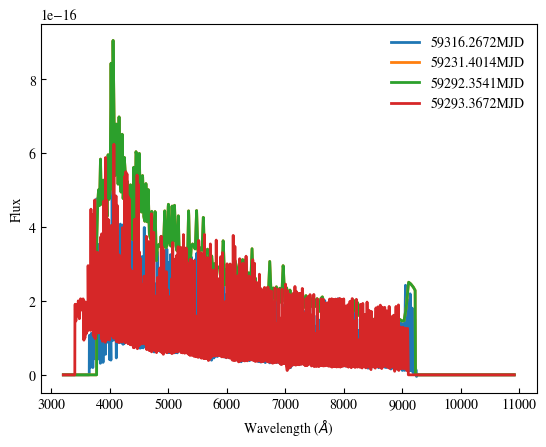

In [5]:
plot_spectra(spectrum, use_lambda_grid=True)

In [6]:
objective_ligtcurve = lightcurves_alercextns[lightcurves_alercextns.oid == spectrum.oid.unique()[0]]
objective_ligtcurve

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf
801329,ZTF21aaahtln,1526278842415015007,712120224.0,59280.278843,2,20.341309,0.186969
801331,ZTF21aaahtln,1514322342415015003,NaN,59268.322349,2,20.076900,0.241257
1453992,ZTF21aaahtln,1465357172415015002,712120224.0,59219.357176,2,18.910633,0.085007
1453993,ZTF21aaahtln,1473447322415015006,NaN,59227.447326,1,18.446000,0.069452
1479586,ZTF21aaahtln,1475426062415015002,712120224.0,59229.426065,2,18.475786,0.077234
1541744,ZTF21aaahtln,1469381092415015004,712120124.0,59223.381100,1,18.514591,0.066307
1590063,ZTF21aaahtln,1463435302415015004,712120124.0,59217.435301,1,18.921488,0.094786
1598451,ZTF21aaahtln,1467405482415015002,NaN,59221.405486,2,18.709300,0.084887
1624705,ZTF21aaahtln,1475445522415015006,NaN,59229.445521,1,18.456300,0.071674
1646699,ZTF21aaahtln,1471447412415015015,NaN,59225.447419,1,18.484400,0.079614


In [7]:
wavelength_lsst = {'u':[3206.34, 4081.51], 'g':[3876.02, 5665.33], 'r':[5377.19, 7055.16],
                   'i':[6765.77, 8325.05], 'z':[8035.39, 9375.47], 'y':[9089.07, 10915.01]}

wavelength_ztf ={'g':[3676.00, 5613.82], 'r':[5497.60, 7394.40], 'i':[6870.97, 8964.61],}

ztf_sv_files  = [file for file in os.listdir('./data/') if 'Palomar' in file]
lsst_sv_files = [file for file in os.listdir('./data/') if 'LSST' in file]

ztf_sv_dict  = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in ztf_sv_files}
lsst_sv_dict = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in lsst_sv_files}

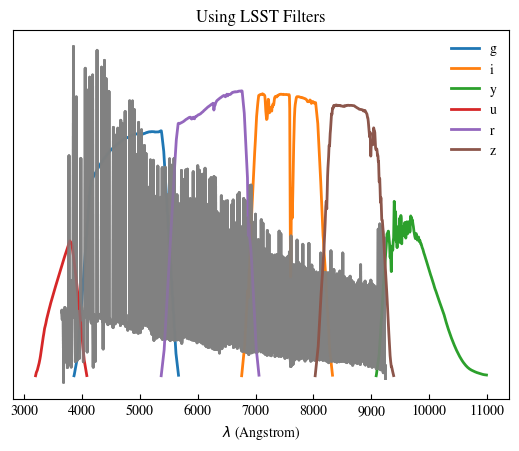

In [8]:
idx_spec = 0
fig, ax = plt.subplots()

for band, sv in lsst_sv_dict.items():
    x, y = zip(*lsst_sv_dict[band])
    x_spectrum = np.linspace(spectrum.iloc[idx_spec].lambda_data_min,spectrum.iloc[idx_spec].lambda_data_max,len(spectrum.iloc[idx_spec].flux_lambda))
    y_spectrum = np.array(spectrum.iloc[idx_spec].flux_lambda)*1e15
    ax.plot(x_spectrum, y_spectrum, alpha = 0.5, color='gray')
    ax.plot(x,y,label=f'{band}')
    ax.set_xlabel(r'$\lambda$ (Angstrom)')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_title('Using LSST Filters')
ax.legend(frameon=False)

plt.show()

In [60]:
def obtain_magnitude_flux(spectrum:pd.DataFrame,instrument:str) -> dict:

    CSPEED = 3e8 # m/s

    if instrument == 'ztf':
        tranmision_dict = ztf_sv_dict
    elif instrument ==  'lsst':
        tranmision_dict = lsst_sv_dict

    x_spectrum = np.linspace(spectrum.lambda_data_min,spectrum.lambda_data_max,len(spectrum.flux_lambda))
    y_spectrum = np.array(spectrum.flux_lambda)

    mags = {}   
    for band, s_wave in tranmision_dict.items():
        band, s_wave = band,s_wave
        wave, s_wave = zip(*tranmision_dict[band])
        wave, s_wave = np.array(wave), np.array(s_wave)

        #condition = np.where((min(wave) < x_spectrum) & (max(wave) > x_spectrum))
        #x = x_spectrum[condition]
        #y = y_spectrum[condition]
        f = interpolate.interp1d(x_spectrum,y_spectrum, fill_value=np.nan, bounds_error=False)
        flux_wave_new = f(wave)

        log_nu = -np.log(wave)                           # Obtaining log_nu in lambda termns
        f_nu   = (wave**2/(CSPEED*1e10)) * flux_wave_new # Obtaining f_nu in lambda termns
        s_nu   = s_wave 

        num = np.trapz(f_nu*s_nu, dx=log_nu[:-1])
        den = np.trapz(s_nu, dx=log_nu[:-1])
        #num_test = simple_integration(wave,f_nu*s_nu, log_nu)
        #den_test = simple_integration(wave,s_nu, log_nu)
        #m = -2.5 * np.log10(num_test/den_test) - 48.60
        m = -2.5 * np.log10(num/den) - 48.60
        mags.update({band:m})
    
    return mags

In [61]:
def obtain_lambda_grid(df:pd.Series) -> list[float]:

    lambda_grid = np.logspace(start=np.log10(df.lambda_grid_min),
                stop=np.log10(df.lambda_grid_max),
                num=df.nlambda_grid)

    return lambda_grid

In [62]:
def interpolate_flux(df:pd.Series) -> list[float]:
    
    lambda_grid = obtain_lambda_grid(df)
    
    flux = np.array(df.flux_lambda)
    lambda_data = np.logspace(start=np.log10(df.lambda_data_min),
                stop=np.log10(df.lambda_data_max),
                num=len(flux))

    f = interpolate.interp1d(lambda_data, flux, fill_value=np.nan, bounds_error=False)
    flux_new = f(lambda_grid)

    return flux_new 


In [63]:
def simpler_intergrate(x:list[float],y:list[float]) -> float:
    
    y = np.nan_to_num(y, nan=0.0)
    
    integral = 0
    
    LSUN = const.L_sun

    for i in range(1,len(x)):
        delta_x = x[i] - x[i-1]
        integral += y[i-1] * delta_x

    return integral

In [64]:
def obtain_luminosity_condition(df:pd.Series, instrument:str):

    lambda_grid = obtain_lambda_grid(df)
    flux = interpolate_flux(df)

    luminosity_list = []

    if instrument == 'ztf':
        bandpasses = ['g','r','i']

        for bandpass in bandpasses:
            condition = np.where((wavelength_ztf[bandpass][0] < lambda_grid) & (wavelength_ztf[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            #y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))
            

    elif instrument == 'lsst':
        bandpasses = ['u','g','r','i','z','y']

        for bandpass in bandpasses:
            condition = np.where((wavelength_lsst[bandpass][0] < lambda_grid) & (wavelength_lsst[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            #y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))

    else:
        return print('There is not that instrument in list')

In [65]:
import matplotlib.lines as mlines

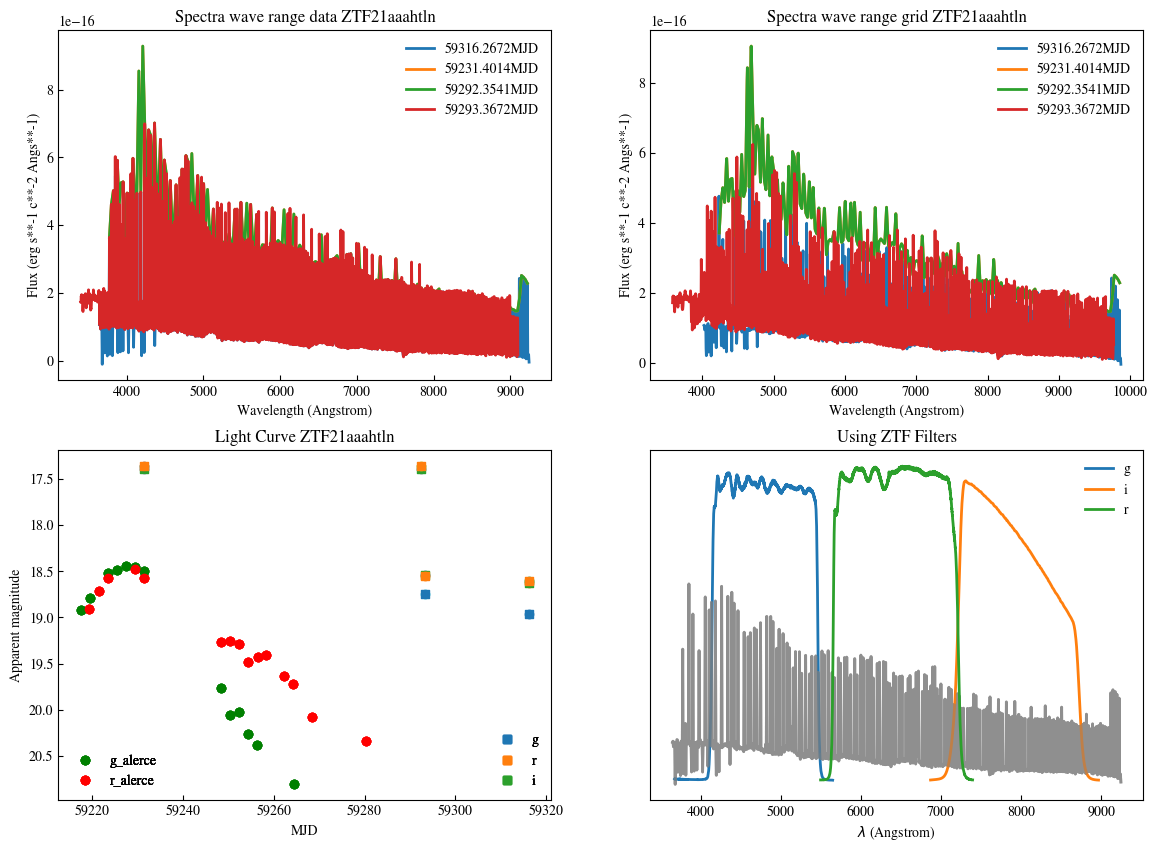

In [71]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(14, 10))
oid = spectrum.oid.unique()[0]
for _, row in spectrum.iterrows():

    # This calculate the x-axis and y-axis of the spectrum
    x_spectrum = np.linspace(row.lambda_data_min,row.lambda_data_max, len(row.flux_lambda))
    y_spectrum = row.flux_lambda

    x_spectrum_grid = np.linspace(row.lambda_grid_min,row.lambda_grid_max, row.nlambda_grid)
    y_spectrum_grid = interpolate_flux(row)

    ax0.plot(x_spectrum, y_spectrum,label=f'{row.mjd:.4f}MJD')
    ax0.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax0.set_xlabel('Wavelength (Angstrom)')
    #ax1.text(x=max(x_spectrum)-500,
    #                 y=max(y_spectrum*2),
    #                 s=f'{row.mjd:.4f}MJD')
    ax0.set_title(f'Spectra wave range data {oid}')
    ax0.legend(frameon=False)

    ax1.plot(x_spectrum_grid, y_spectrum_grid,label=f'{row.mjd:.4f}MJD')
    ax1.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax1.set_xlabel('Wavelength (Angstrom)')
    ax1.set_title(f'Spectra wave range grid {oid}')
    ax1.legend(frameon=False)

    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        ax2.scatter(x=group.mjd, y=group.magpsf, color=color)
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    for bandapass, magnitude in magnitude_integrated.items():
        ax2.scatter(row.mjd,magnitude)
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            #label = 
            ax2.scatter(row.mjd,magnitude, marker='s',color = color)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax2.scatter(row.mjd,magnitude, marker='s',color = color)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax2.legend(handles, bands, loc='lower right',frameon=False)
    ax2.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax2.legend(handles, ['g_alerce', 'r_alerce'], loc='lower left',frameon=False)
    ax2.add_artist(leg2)

    ax2.yaxis.set_inverted(True)
    ax2.set_xlabel('MJD')
    ax2.set_ylabel('Apparent magnitude')
    ax2.set_title(f'Light Curve {oid}')

idx_spec = 0
for band, sv in ztf_sv_dict.items():
    x, y = zip(*ztf_sv_dict[band])
    x_spectrum = np.linspace(spectrum.iloc[idx_spec].lambda_data_min,spectrum.iloc[idx_spec].lambda_data_max,len(spectrum.iloc[idx_spec].flux_lambda))
    y_spectrum = np.array(spectrum.iloc[idx_spec].flux_lambda)*1e15
    ax3.plot(x_spectrum, y_spectrum, alpha = 0.5, color='gray')
    ax3.plot(x,y,label=f'{band}')
    ax3.set_xlabel(r'$\lambda$ (Angstrom)')
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_title('Using ZTF Filters')
ax3.legend(frameon=False)
plt.show()

Calcualte the magnitud

https://articles.adsabs.harvard.edu/pdf/1996AJ....111.1748F

In [ ]:
def simple_integration(x:list[float],y:list[float],delta_x:list[float]) -> float:
    y = np.nan_to_num(y, nan=0.0)

    if delta_x == None:
        delta_x = x[i] 

    integral = 0
    for i in range(len(delta_x)-1):
        integral += (y[i] + y[i+1]) * delta_x[i] / 2.0
    return integral